In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree

time_conv = 977.79222167

In [2]:
sim_list = ['phantom-vacuum-grav', 'phantom-vacuum', 'phantom-Sg10-Rc4.0', 'phantom-vacuum-Sg10-Rc4.0',
            'phantom-vacuum-Sg20-Rc4.0', 'Nbody', 'phantom-vacuum-Sg20-Rc3.5']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f



In [3]:
# sn0_list = []
# sn2_list = []
# sn3_list = []
# sn4_list = []
sn5_list = []
sn6_list = []
sn6i_list = []
idx_list = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]#, 100, 125]
fields=['Coordinates', 'Velocities', 'Masses', 'Acceleration']
for idx in tqdm(idx_list):
#     sn0 = read_snap(idx, 0, parttype=None, fields=None)
#     sn0_list.append(sn0)
    
#     sn2 = read_snap(idx, 2, parttype=None, fields=None)
#     sn2_list.append(sn2)
    
#     sn3 = read_snap(idx, 3, parttype=None, fields=None)
#     sn3_list.append(sn3)
    
#     sn4 = read_snap(idx, 4, parttype=None, fields=None)
#     sn4_list.append(sn4)

    sn5 = read_snap(idx, 5, parttype=None, fields=fields)
    sn5_list.append(sn5)

    try:
        sn6 = read_snap(idx, 6, parttype=None, fields=fields)
        sn6_list.append(sn6)
    except:
        pass

#     try:
#         sn6i = read_snap(idx, 6, lvl='lvl3-isotherm', parttype=None, fields=None)
#         sn6i_list.append(sn6i)
#     except:
#         pass


A Jupyter Widget

In [8]:
def compute_angmom(sn, ntype=6, center=np.array([200, 200, 200])):
    ang_mom_tot = np.zeros(ntype)
    
    for i in range(ntype):
        if sn.NumPart_Total[i] > 0:
#             print('doing', i)
            part = getattr(sn, 'part'+str(i))
            pos = part.Coordinates.value - center
            vel = part.Velocities.value
            if hasattr(part, 'Masses'):
                mom = vel * part.Masses
            else:
                mom = vel * sn.MassTable[i]
                
#             print(vel[0])
#             print(mom[0])
            
            # compute z component of angular momentum
            ang_mom = pos[:,0]*mom[:,1] - mom[:,0] * pos[:,1]
            
#             print(np.sum(ang_mom))
            ang_mom_tot[i] = np.sum(ang_mom)
    
    return ang_mom_tot

def compute_mominertia(sn, ntype=6, center=np.array([200, 200, 200])):
    mominert_tot = np.zeros(ntype)
    
    for i in range(ntype):
        if sn.NumPart_Total[i] > 0:
#             print('doing', i)
            part = getattr(sn, 'part'+str(i))
            pos = part.Coordinates.value - center
            if hasattr(part, 'Masses'):
                mass = part.Masses.value
            else:
                mass = np.full(sn.NumPart_Total[i], sn.MassTable[i])
                
            
            R = np.linalg.norm(pos[:,:2], axis=1)
            
            mominert_tot[i] = np.sum(mass * R * R)
    
    return mominert_tot

def get_cyl(sn, pt, center=np.array([200, 200, 200])):
    part = getattr(sn, 'part'+str(pt))
    pos = part.pos.value - center
    vel = part.vel.value
    
    R = np.linalg.norm(pos[:,:2], axis=1)
    phi = np.arctan2(pos[:,1], pos[:,0])
    z = pos[:,2]
    
    cosphi = pos[:,0]/R
    sinphi = pos[:,1]/R
    
    vR = cosphi * vel[:,0] + sinphi * vel[:,1]
    vphi = cosphi * vel[:,1] - sinphi * vel[:,0]
    vz = vel[:,2]
    
    return np.transpose([R, phi, z, vR, vphi, vz])
    

In [5]:
angmom5_list = []
for i,idx in enumerate(tqdm(idx_list)):
    angmom5_list.append(compute_angmom(sn5_list[i], center=np.array([0, 0, 0])))
angmom5_list = np.array(angmom5_list)

A Jupyter Widget

In [6]:
mominert5_list = []
for i,idx in enumerate(tqdm(idx_list)):
    mominert5_list.append(compute_mominertia(sn5_list[i], center=np.array([0, 0, 0])))
mominert5_list = np.array(mominert5_list)

A Jupyter Widget

In [7]:
time5_list = []
for i,idx in enumerate(tqdm(idx_list)):
    time5_list.append(sn5_list[i].Time)
time5_list = np.array(time5_list)

A Jupyter Widget

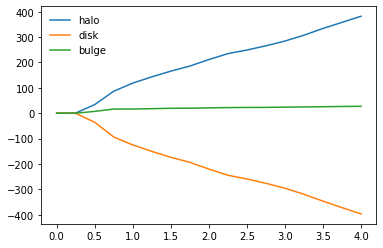

In [41]:
plt.plot(time5_list, angmom5_list[:,1] - angmom5_list[:,1][0], label='halo')
plt.plot(time5_list, angmom5_list[:,2] - angmom5_list[:,2][0], label='disk')
plt.plot(time5_list, angmom5_list[:,3] - angmom5_list[:,3][0], label='bulge')
plt.legend(frameon=False)
plt.show()

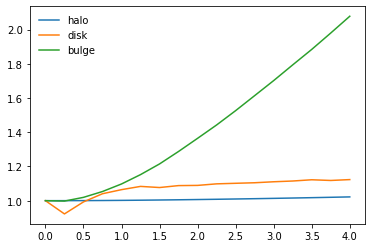

In [52]:
plt.plot(time5_list, mominert5_list[:,1]/mominert5_list[:,1][0], label='halo')
plt.plot(time5_list, mominert5_list[:,2]/mominert5_list[:,2][0], label='disk')
plt.plot(time5_list, mominert5_list[:,3]/mominert5_list[:,3][0], label='bulge')
plt.legend(frameon=False)
plt.show()

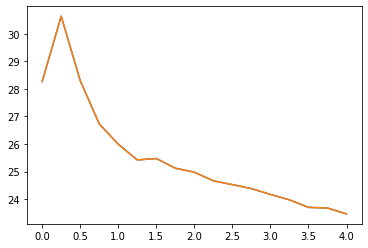

In [9]:
plt.plot(time5_list, angmom5_list[:,2]/mominert5_list[:,2])
plt.show()

In [45]:
pos = sn.part2.pos.value
pos[:,:2]

array([[-15.14073467,   5.11183929],
       [-15.1897316 ,   4.96386576],
       [-15.45166016,   5.14432335],
       ...,
       [  0.90504926,  -0.42274863],
       [  0.9000057 ,  -0.42811206],
       [  0.93634176,  -0.41287401]])

In [12]:
import matplotlib as mpl
def quick_projection(x, y, m, width=20, nres=256, vmin=1E-3, vmax=1E0):
    extent = [-width/2.0, width/2.0, -width/2.0, width/2.0]
    range_xy = [[extent[0], extent[1]], [extent[0], extent[1]]]
    surf = (width/nres)**2.
    
    heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)
    heatmap_xy *= m/surf
    
    fig, ax = plt.subplots(1, 1)
    
    ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), vmin=vmin, vmax=vmax)
    
    return fig, ax

def quick_projection_key(x, y, m, key, width=20, nres=256, vmin=1E-3, vmax=1E0):
    extent = [-width/2.0, width/2.0, -width/2.0, width/2.0]
    range_xy = [[extent[0], extent[1]], [extent[0], extent[1]]]
    surf = (width/nres)**2.
    
    key_not = np.logical_not(key)
    
    heatmap_xy, _, _ = np.histogram2d(x[key], y[key], bins=(nres, nres), range=range_xy)
    heatmap_xy_not, _, _ = np.histogram2d(x[key_not], y[key_not], bins=(nres, nres), range=range_xy)
    heatmap_xy *= m/surf
    heatmap_xy_not *= m/surf
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    
    ax[0].imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), vmin=vmin, vmax=vmax)
    ax[1].imshow(heatmap_xy_not.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), vmin=vmin, vmax=vmax)
    
    return fig, ax

In [36]:
sn = sn5_list[-1]
cyl = get_cyl(sn, 2, center=np.array([0, 0, 0]))

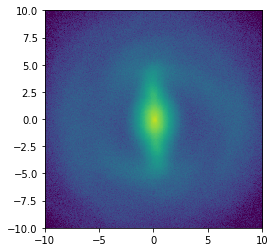

In [17]:
fig, ax = quick_projection(sn.part2.pos[:,0], sn.part2.pos[:,1], sn.MassTable[2])
plt.show()

4.0


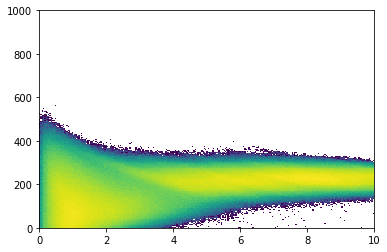

32.03587060239795


In [73]:
R = cyl[:,0]
vphi = cyl[:,4]
vR = cyl[:,3]
# plt.hist(vphi/R, bins=100)
rng = [[0, 10], [0, 1000]]
extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]
heatmap, _, _ = np.histogram2d(R, vphi, bins=(256, 256), range=rng)

print(sn.Time)
plt.imshow(heatmap.T, origin='lower', extent=extent, norm=mpl.colors.LogNorm(), aspect='auto')
# plt.scatter(R, vphi/R)
plt.show()
print(np.median(vphi/R))

4.0


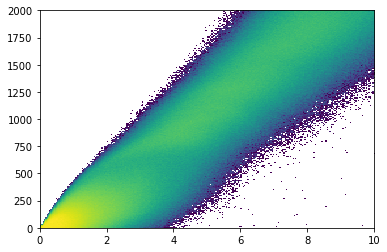

32.03587060239795


In [80]:
R = cyl[:,0]
vphi = cyl[:,4]
vR = cyl[:,3]
# plt.hist(vphi/R, bins=100)
rng = [[0, 10], [0, 2000]]
extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]
heatmap, _, _ = np.histogram2d(R, R*vphi, bins=(256, 256), range=rng)

print(sn.Time)
plt.imshow(heatmap.T, origin='lower', extent=extent, norm=mpl.colors.LogNorm(), aspect='auto')
# plt.scatter(R, vphi/R)
plt.show()
print(np.median(vphi/R))

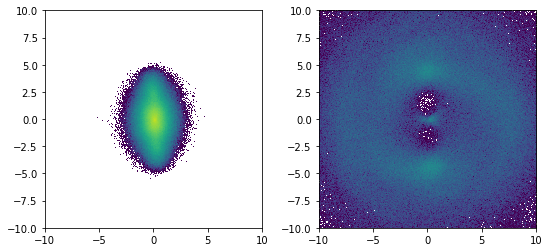

In [74]:
x, y = sn.part2.pos[:,0].value, sn.part2.pos[:,1].value

R = cyl[:,0]
vphi = cyl[:,4]
vR = cyl[:,3]

# key = R * vphi < np.minimum(200 + 100*R, 400)
# key = R * vphi < 300
key = vphi < 400 - 400 * (R/6)
fig, ax = quick_projection_key(x, y, sn.MassTable[2], key, nres=512)
plt.show()

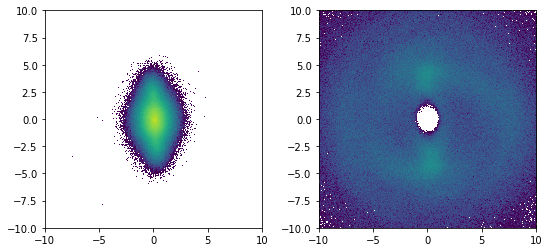

In [15]:
x, y = sn.part2.pos[:,0].value, sn.part2.pos[:,1].value

R = cyl[:,0]
vphi = cyl[:,4]
vR = cyl[:,3]

# key = R * vphi < np.minimum(200 + 100*R, 400)
key = R * vphi < 400
fig, ax = quick_projection_key(x, y, sn.MassTable[2], key, nres=512)
plt.show()

4.0


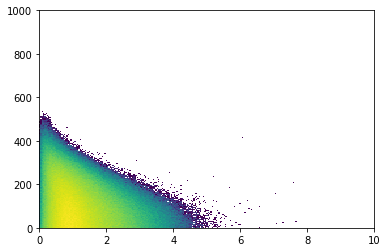

32.03587060239795


In [62]:
R = cyl[:,0]
vphi = cyl[:,4]
vR = cyl[:,3]
# plt.hist(vphi/R, bins=100)
rng = [[0, 10], [0, 1000]]
extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]
key = R * vphi < 300
heatmap, _, _ = np.histogram2d(R[key], vR[key], bins=(256, 256), range=rng)

print(sn.Time)
plt.imshow(heatmap.T, origin='lower', extent=extent, norm=mpl.colors.LogNorm(), aspect='auto')
# plt.scatter(R, vphi/R)
plt.show()
print(np.median(vphi/R))

In [16]:
sn = sn5_list[-1]

tree_pos1 = np.float64(sn.part1.pos.value)
tree_mass1 = np.float64(np.full(sn.NumPart_Total[1], sn.MassTable[1]))#.reshape((sn.NumPart_Total[2],))
tree_softening1 = np.float64(np.full(sn.NumPart_Total[1], sn.parameters.SofteningComovingType1))

cyl = get_cyl(sn, 2, center=np.array([0., 0., 0.]))
R = cyl[:,0]
vphi = cyl[:,4]
bar_key = R * vphi < 400 
disk_key = np.logical_not(bar_key)

tree_pos2b = np.float64(sn.part2.pos.value[bar_key])
tree_mass2b = np.float64(np.full(len(np.where(bar_key)[0]), sn.MassTable[2]))#.reshape((sn.NumPart_Total[2],))
tree_pos2d = np.float64(sn.part2.pos.value[disk_key])
tree_mass2d = np.float64(np.full(len(np.where(disk_key)[0]), sn.MassTable[2]))#.reshape((sn.NumPart_Total[2],))

tree_pos3 = np.float64(sn.part3.pos.value)
tree_mass3 = np.float64(np.full(sn.NumPart_Total[3], sn.MassTable[3]))#.reshape((sn.NumPart_Total[2],))




In [17]:
from pyMND.forcetree import force_treeevaluate_loop, construct_tree

In [18]:
tree1 = construct_tree(tree_pos1, tree_mass1, 0.35, sn.parameters.SofteningComovingType1)
tree2b = construct_tree(tree_pos2b, tree_mass2b, 0.35, sn.parameters.SofteningComovingType2)
tree2d = construct_tree(tree_pos2d, tree_mass2d, 0.35, sn.parameters.SofteningComovingType2)
tree3 = construct_tree(tree_pos3, tree_mass3, 0.35, sn.parameters.SofteningComovingType3)

In [19]:
%%time
G = 43007.1
acc1 = G * np.array(force_treeevaluate_loop(tree_pos2b, tree1, 32))
acc2b = G * np.array(force_treeevaluate_loop(tree_pos2b, tree2b, 32))
acc2d = G * np.array(force_treeevaluate_loop(tree_pos2b, tree2d, 32))
acc3 = G * np.array(force_treeevaluate_loop(tree_pos2b, tree3, 32))

CPU times: user 53min 6s, sys: 23.3 s, total: 53min 29s
Wall time: 2min 27s


In [20]:
torque1 = np.sum(tree_pos2b[:,0] * acc1[:,1] - tree_pos2b[:,1] * acc1[:,0])
torque2b = np.sum(tree_pos2b[:,0] * acc2b[:,1] - tree_pos2b[:,1] * acc2b[:,0])
torque2d = np.sum(tree_pos2b[:,0] * acc2d[:,1] - tree_pos2b[:,1] * acc2d[:,0])
torque3 = np.sum(tree_pos2b[:,0] * acc3[:,1] - tree_pos2b[:,1] * acc3[:,0])

In [22]:
print(torque1/torque1, torque2b/torque1, torque2d/torque1, torque3/torque1)

1.0 -0.002008764391889632 0.6985788297128516 -0.0733536223673304


In [9]:
G = 43007.1
frc1 = np.array(force_treeevaluate(tree_pos2[0], tree1))
frc2 = np.array(force_treeevaluate(tree_pos2[0], tree2))
frc3 = np.array(force_treeevaluate(tree_pos2[0], tree3))
print((frc1 + frc2 + frc3)*G)

NameError: name 'force_treeevaluate' is not defined

In [10]:
sn.part2.acce[0]

array([-37106.31665745,  21622.40925104,   6600.18953693])

In [15]:
%%time
acc1 = np.array(force_treeevaluate_loop(tree_pos2, tree1, 32))
acc2 = np.array(force_treeevaluate_loop(tree_pos2, tree2, 32))
acc3 = np.array(force_treeevaluate_loop(tree_pos2, tree3, 32))

CPU times: user 47min 29s, sys: 6.05 s, total: 47min 35s
Wall time: 3min 17s


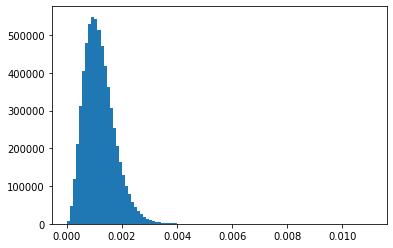

In [26]:
acc_tot = G*(acc1 + acc2 + acc3)
acc_diff = acc_tot - sn.part2.acce
acc_diff_mag = np.linalg.norm(acc_diff, axis=1)
acc_mag = np.linalg.norm(sn.part2.acce, axis=1)
plt.hist(acc_diff_mag/acc_mag, bins=100)
plt.show()

In [27]:
np.max(acc_diff_mag/acc_mag)

0.01104936395573607

In [14]:
from pykdgrav import ConstructKDTree, GetAccel, GetAccelParallel

In [16]:
tree1 = ConstructKDTree(tree_pos1, tree_mass1, tree_softening1)

In [29]:
%%time
acc1 = GetAccel(tree_pos2[:10000], tree1, G=43007.1, theta=0.7)

CPU times: user 4.02 s, sys: 30 ms, total: 4.05 s
Wall time: 4.06 s
